<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Web Server Log Analysis with Apache Spark**

## Why Server Log Analysis is a suitable Big Data Problem
* ### Very large and common data source
* ### Sensitive information
* ### Requires repeated and quick corrective action

## Exploratory Data Analysis on the web log data

Let's begin looking at our data.  For this lab, we will use a data set from NASA Kennedy Space Center web server in Florida. The full data set is freely available at <http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html>, and it contains all HTTP requests for two months. We are using a subset that only contains several days' worth of requests.  The log file has already been downloaded for you.

In [1]:
import sys
import os

log_file_path = '../files/NASA_access_log_Aug95'

### Loading the log file

Now that we have the path to the file, let's load it into a DataFrame. We'll do this in steps. First, we'll use `sqlContext.read.text()` to read the text file. This will produce a DataFrame with a single string column called `value`.

In [2]:
base_df = sqlContext.read.text(log_file_path)
# Let's look at the schema
base_df.printSchema()

root
 |-- value: string (nullable = true)



Let's take a look at some of the data.

In [3]:
base_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839     |
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                               |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                             |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0"

### Parsing the log file

This is in [Common Log Format](https://www.w3.org/Daemon/User/Config/Logging.html#common-logfile-format). The fields are:


| field         | meaning                                                                |
| ------------- | ---------------------------------------------------------------------- |
| _remotehost_  | Remote hostname (or IP number if DNS hostname is not available).       |
| _rfc931_      | The remote logname of the user. We don't really care about this field. |
| _authuser_    | The username of the remote user, as authenticated by the HTTP server.  |
| _[date]_      | The date and time of the request.                                      |
| _"request"_   | The request, exactly as it came from the browser or client.            |
| _status_      | The HTTP status code the server sent back to the client.               |
| _bytes_       | The number of bytes (`Content-Length`) transferred to the client.      |


How to extract these fields from the each record?

Use the built-in [regexp\_extract()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_extract)
function to do the parsing. This function matches a column against a regular expression with one or more [capture groups](http://regexone.com/lesson/capturing_groups) and allows you to extract the match.

We will use one regex for each field.

In [4]:
from pyspark.sql.functions import split, regexp_extract
split_df = base_df.select(regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
                          regexp_extract('value', r'^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]', 1).alias('timestamp'),
                          regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
                          regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('status'),
                          regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size'))
split_df.show()

+--------------------+--------------------+--------------------+------+------------+
|                host|           timestamp|                path|status|content_size|
+--------------------+--------------------+--------------------+------+------------+
|  in24.inetnebr.com |01/Aug/1995:00:00...|/shuttle/missions...|   200|        1839|
|    uplherc.upl.com |01/Aug/1995:00:00...|                   /|   304|           0|
|    uplherc.upl.com |01/Aug/1995:00:00...|/images/ksclogo-m...|   304|           0|
|    uplherc.upl.com |01/Aug/1995:00:00...|/images/MOSAIC-lo...|   304|           0|
|    uplherc.upl.com |01/Aug/1995:00:00...|/images/USA-logos...|   304|           0|
|ix-esc-ca2-07.ix....|01/Aug/1995:00:00...|/images/launch-lo...|   200|        1713|
|    uplherc.upl.com |01/Aug/1995:00:00...|/images/WORLD-log...|   304|           0|
|slppp6.intermind....|01/Aug/1995:00:00...|/history/skylab/s...|   200|        1687|
|piweba4y.prodigy....|01/Aug/1995:00:00...|/images/launchmed...| 

### Data Cleaning - Did the parsing logic work?
#### How many null rows are there in the dataframe?

In [5]:
base_df.filter(base_df['value'].isNull()).count()

0

#### How many rows with null columns?

In [12]:
bad_rows_df = split_df.filter(split_df['host'].isNull() |
                              split_df['timestamp'].isNull() |
                              split_df['path'].isNull() |
                              split_df['status'].isNull() |
                             split_df['content_size'].isNull())
bad_rows_df.count()

14178

#### Which columns have null values?

In [6]:
from pyspark.sql.functions import col, sum

def count_null(col_name):
  return sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
#
# This could be done in one line with a Python list comprehension, but we're keeping
# it simple for those who don't know Python very well.
exprs = []
for col_name in split_df.columns:
  exprs.append(count_null(col_name))

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
split_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|       14178|
+----+---------+----+------+------------+



#### Q: What went wrong?

In [7]:
bad_content_size_df = base_df.filter(~ base_df['value'].rlike(r'\d+$'))
bad_content_size_df.count()

14178

#### If these values don't end in digits, then what are the trailing characters?

In [8]:
bad_content_size_df.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                      |
+---------------------------------------------------------------------------------------------------------------------------+
|gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -                            |
|js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -|
|tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -                               |
|itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -         |
|grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -           

#### Q: What does the `-` mean and how to fix it?

### Fix the rows with invalid `content_size`

* [fillna()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.fillna), which fills null values with specified non-null values.
* [na](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.na), which returns a [DataFrameNaFunctions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameNaFunctions) object with many functions for operating on null columns.

In [9]:
# Replace all null content_size values with 0.
cleaned_df = split_df.na.fill({'content_size': 0})

In [10]:
# Ensure that there are no nulls left.
exprs = []
for col_name in cleaned_df.columns:
  exprs.append(count_null(col_name))

cleaned_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|           0|
+----+---------+----+------+------------+



### Parsing the timestamp.

In [12]:
from pyspark.sql.functions import udf

In [13]:
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(s):
    """ Convert Common Log time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring time zone here. In a production application, you'd want to handle that.
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(s[7:11]),
      month_map[s[3:6]],
      int(s[0:2]),
      int(s[12:14]),
      int(s[15:17]),
      int(s[18:20])
    )

u_parse_time = udf(parse_clf_time)

logs_df = cleaned_df.select('*', u_parse_time(cleaned_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
total_log_entries = logs_df.count()

In [14]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- path: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [17]:
logs_df.limit(10).toPandas().head()

,host,path,status,content_size,time
0,in24.inetnebr.com,/shuttle/missions/sts-68/news/sts-68-mcc-05.txt,200,1839,1995-08-01 00:00:01
1,uplherc.upl.com,/,304,0,1995-08-01 00:00:07
2,uplherc.upl.com,/images/ksclogo-medium.gif,304,0,1995-08-01 00:00:08
3,uplherc.upl.com,/images/MOSAIC-logosmall.gif,304,0,1995-08-01 00:00:08
4,uplherc.upl.com,/images/USA-logosmall.gif,304,0,1995-08-01 00:00:08


In [18]:
logs_df.cache()

DataFrame[host: string, path: string, status: int, content_size: int, time: timestamp]

## Analysis Walk-Through on the Web Server Log File

### Example: Content Size Statistics

We can compute the statistics by calling `.describe()` on the `content_size` column of `logs_df`.  The `.describe()` function returns the count, mean, stddev, min, and max of a given column.

In [26]:
# Calculate statistics based on the content size.
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           1569898|
|   mean|17089.225812122826|
| stddev| 67954.76392157092|
|    min|                 0|
|    max|           3421948|
+-------+------------------+

+-------------------+
|count(content_size)|
+-------------------+
|            1569898|
+-------------------+



### Exercise: Use the `sql_funcs.{count, mean, stddev, min, max}` functions to verify the summary statistics

In [ ]:
from pyspark.sql import functions as sql_funcs

In [ ]:
# enter code here

### Example: HTTP Status Analysis

In [27]:
status_to_count_df =(logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

status_to_count_length = status_to_count_df.count()
print('Found %d response codes' % status_to_count_length)
status_to_count_df.show()

Found 8 response codes
+------+-------+
|status|  count|
+------+-------+
|   200|1398988|
|   302|  26497|
|   304| 134146|
|   400|     10|
|   403|    171|
|   404|  10056|
|   500|      3|
|   501|     27|
+------+-------+



### Example: Plotting the status counts

In [28]:
%matplotlib inline

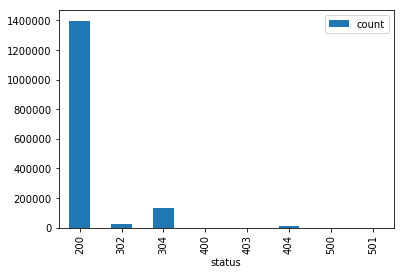

In [29]:
status_to_count_df.limit(10).toPandas().set_index('status', drop=True).plot(kind='bar')

### Q: What is wrong with this graph?

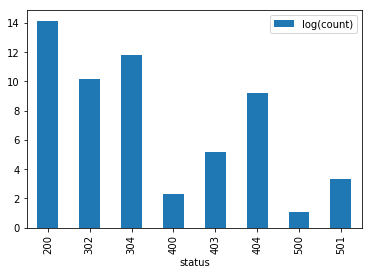

In [31]:
log_status_to_count_df = status_to_count_df.withColumn('log(count)',
                                                       sql_funcs.log(status_to_count_df['count']))

log_status_to_count_df.select('status', 'log(count)').toPandas().set_index('status', drop=True).plot(kind='bar')

### Exercise: Find the top 20 most frequent hosts from the database.

In [48]:
# enter code here

###  Analyzing Web Server Log File

### Exercise: Top Ten Error Paths
#### Hint: An error is any HTTP request that does not have a return status of 200.
#### Hint: Use the `filter` operation, followed by grouping and sorting

In [54]:
# enter code here

#### Exercise: Number of Unique Hosts

In [57]:
# enter code here

## Exploring 404 Status Codes

404 errors are returned when the server cannot find the resource (page or object) the browser or client requested.

### Exercise: Counting 404 Response Codes

How many 404 records are in the log?

In [99]:
# enter code here

### Exercise: List the Top Twenty 404 Response Code paths

In [62]:
# enter code here